## A feed-forward model for WISDM 

In [29]:
import os 
import pandas as pd 
import torch 
import torch.nn as nn 
import numpy as np 
import networkx as nx 
from torch_geometric.data import InMemoryDataset, Data
# from prep_mhealth import prep_mhealth
# from prep_wisdm import prep_wisdm
from torch.nn import Linear 
import torch.optim as optim 
from torch_geometric.nn import GCNConv
import time
import tqdm 
import random
import copy
from torch.utils.data import Dataset, DataLoader
import datetime as dttm 
import argparse
from mlflow import log_metric, log_param, log_artifacts
import mlflow 

In [2]:
os.getcwd()
os.chdir('../scripts')
from prep_mhealth import prep_mhealth
from prep_wisdm import prep_wisdm
from model_utils import * 
os.chdir('../')

In [3]:
os.getcwd()

'c:\\Users\\abhi\\Documents\\GEEK\\GNN\\ours'

In [4]:
from matplotlib import pyplot as plt 
%pylab inline

Populating the interactive namespace from numpy and matplotlib
C:\Users\abhi\anaconda3\envs\dl\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [8]:
num_class = 6
input_dim = 3
BATCH_SIZE = 8
DATADIR  = 'data/processed/wisdm'

In [128]:
agents = os.listdir(DATADIR)
train_x = []
test_x = []
train_y = []
test_y = []

for each_agent in agents: 
    x = pd.read_csv(os.path.join(DATADIR, each_agent, 'node_attributes.txt'), 
                header = None)
    
    y = pd.read_csv(os.path.join(DATADIR, each_agent, 'node_labels.txt'), 
                    header = None)
    
    trn_msk = pd.read_csv(os.path.join(DATADIR, each_agent, 'train_mask.txt'), 
                    header = None)

    train_x.append(x[trn_msk.values.reshape(-1, 1)])
    test_x.append(x[~trn_msk.values.reshape(-1, 1)])
    train_y.append(y[trn_msk.values.reshape(-1, 1)])
    test_y.append(y[~trn_msk.values.reshape(-1, 1)])

hardata_trn = SimpleHAR(train_x, train_y)
hardata_val = SimpleHAR(test_x, test_y)


In [159]:
# training_data = MyData(train_data)
trainloader = DataLoader(hardata_trn, batch_size= 256)
validationloader = DataLoader(hardata_val, batch_size = 32)
x, y = next(iter(trainloader))

print(x.size())
print(y.size())

torch.Size([256, 3])
torch.Size([256, 1])


In [249]:
class MyModel(nn.Module): 
    def __init__(self):
        super().__init__() 
        self.linear_stack = nn.Sequential(
            nn.Linear(3, 64), 
            
            nn.Dropout(),
            nn.ReLU(), 
            nn.Linear(64, 64),
           
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
    def forward(self, x): 
        return self.linear_stack(x)

In [250]:
model = MyModel()
optimizer = torch.optim.Adam(model.parameters()) 
loss_fun = nn.CrossEntropyLoss()

In [251]:
epoch_loss = []
accuracy = [] 
for epoch in tqdm.tqdm(range(500)):
    b_loss = 0   
    for i, (x,y) in enumerate(trainloader): 
        preds = model(x)
        loss = loss_fun(preds, y.squeeze() - 1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b_loss+= loss.item()
    epoch_loss.append(b_loss / i)

    # validation loop: 
    num_correct = 0 
    n  = 0 
    for j, (tx,ty) in enumerate(validationloader): 
        with torch.no_grad():
            preds = model(tx)
            val_y = torch.max(preds, 1)[1]
            num_correct += torch.mean(1 * torch.eq(ty-1, val_y).float()).item()
    
    accuracy.append(num_correct / j)
    if epoch % 50 == 49: 
        print('Epoch: {0}, Accuracy: {1:.2f}'.format(epoch, accuracy[-1]))

100%|██████████| 500/500 [16:04<00:00,  1.93s/it]Epoch: 499, Accuracy: 0.41



In [248]:
x.size()

torch.Size([256, 3])

Text(0.5, 0, 'epoch')

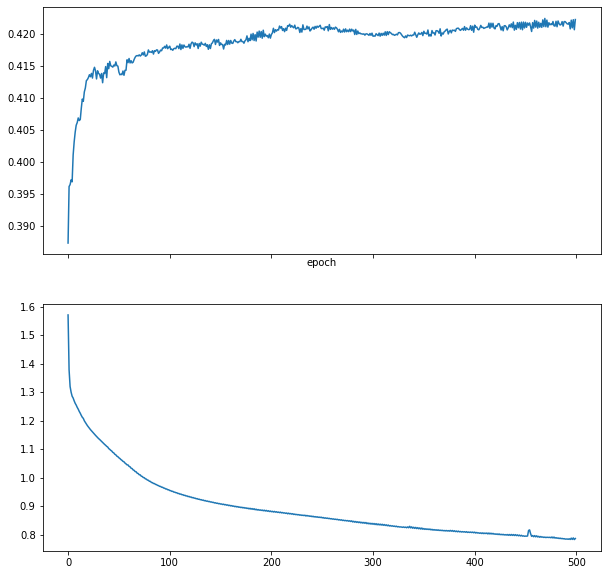

In [238]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex= True, figsize= (10, 10))
ax1.plot(accuracy)
ax2.plot(epoch_loss)
ax1.set_xlabel('epoch')

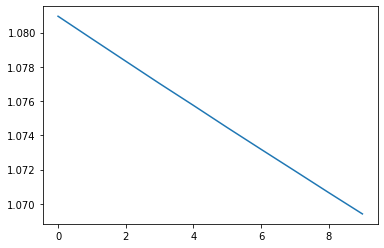